In [ ]:
# import pandas as pd
# import glob

# csv_files = glob.glob("*.csv")
# dataframes = [pd.read_csv(file) for file in csv_files]

# merged_df = pd.concat(dataframes, ignore_index=True)
# merged_df.to_csv("merged_output.csv", index=False)


Threshold for classification: 0.98


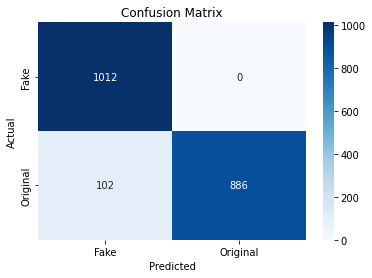

Accuracy: 0.949
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1012
           1       1.00      0.90      0.95       988

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

f(LL, LH, HL, HH) = 13.5*LL + 1.5*LH + 2.0*HL + -2.7*HH + -263.6
If f(LL, LH, HL, HH) >= 1.0, classify as ORIGINAL, else classify as FAKE.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("merged_output.csv")

df["Label"] = df["Folder"].apply(lambda x: 1 if x == "..." else 0)

X = df[["LL Energy", "LH Energy", "HL Energy", "HH Energy"]].values
y = df["Label"].values  

X_log_transformed = np.log1p(X)

df_original = df[df["Label"] == 1]
df_fake = df[df["Label"] == 0]
num_samples_needed = len(df_fake) - len(df_original)
new_originals = df_original.sample(n=num_samples_needed, replace=True).copy()


for col in ["LL Energy", "LH Energy", "HL Energy", "HH Energy"]:
    new_originals[col] += np.random.uniform(-0.001, 0.001, size=len(new_originals))

df_balanced = pd.concat([df, new_originals], ignore_index=True)

X_balanced = df_balanced[["LL Energy", "LH Energy", "HL Energy", "HH Energy"]].values
y_balanced = df_balanced["Label"].values  

X_balanced_log_transformed = np.log1p(X_balanced)

X_train, X_test, y_train, y_test = train_test_split(X_balanced_log_transformed, y_balanced, test_size=0.2, random_state=42)
poly = PolynomialFeatures(degree=1, include_bias=False) # for model weights and biases
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model = LogisticRegression(max_iter=1000)  # for threshold
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_prob = model.predict_proba(X_test_poly)[:, 1]


threshold = np.mean(y_prob[y_test == 1])
print(f"Threshold for classification: {threshold:.2f}")

final_predictions = (y_prob >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, final_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Original"], yticklabels=["Fake", "Original"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))
coefficients = model.coef_.flatten()
intercept = model.intercept_[0]

terms = poly.get_feature_names_out(["LL", "LH", "HL", "HH"])
equation = " + ".join([f"{coeff:.1f}*{term}" for coeff, term in zip(coefficients, terms)])
equation += f" + {intercept:.1f}"
print(f"f(LL, LH, HL, HH) = {equation}")

print(f"If f(LL, LH, HL, HH) >= {threshold:.1f}, classify as ORIGINAL, else classify as FAKE.")


In [ ]:
def classify_sample(LL, LH, HL, HH):
    f_value = 13.5*LL + 1.5*LH + 2.0*HL + -2.7*HH + -263.6
    return "ORIGINAL" if f_value >= 1.0 else "FAKE"

In [ ]:

new_sample = np.array([282972362, 582249, 1931993, 475466])  # [LL, LH, HL, HH]
new_sample_log_transformed = np.log1p(new_sample)
prediction = classify_sample(*new_sample_log_transformed)

print(f"Predicted class: {prediction}")


Predicted class: ORIGINAL
